In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv(r'D:\Downloads\DailyDelhiClimateTrain.csv')
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [3]:
df_test = pd.read_csv(r'D:\Downloads\DailyDelhiClimateTest.csv')
df_test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [6]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace= True)

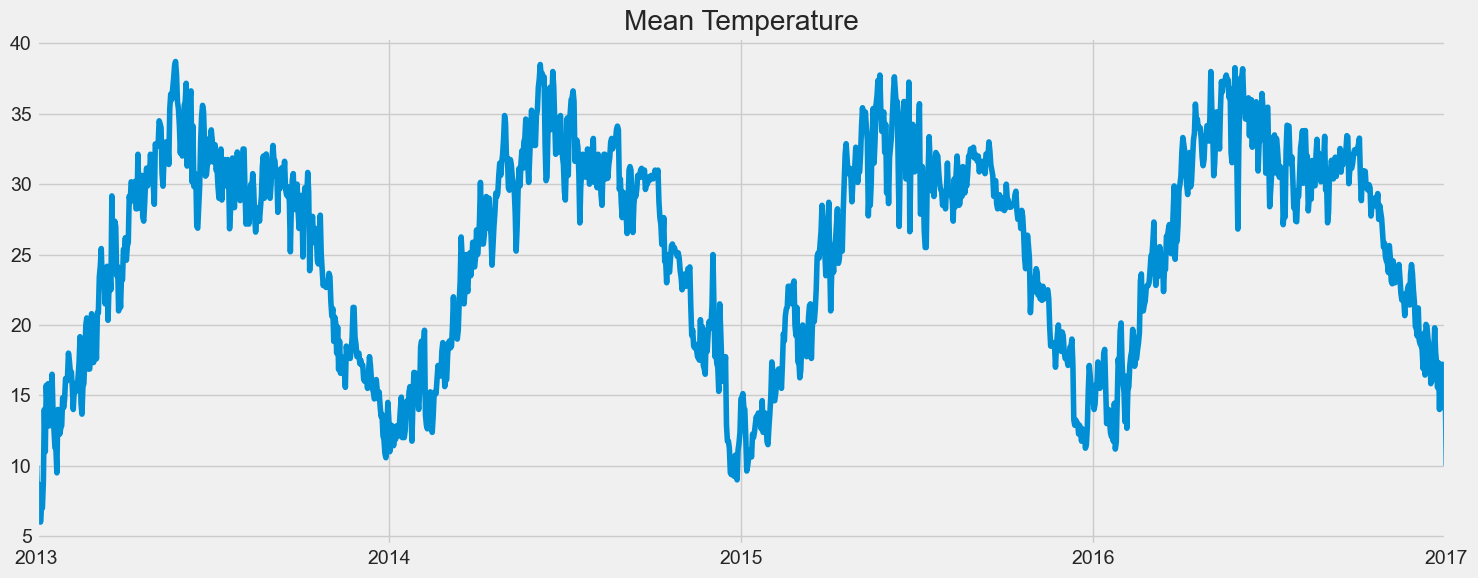

In [7]:
plt.figure(figsize=(15, 6))
df['meantemp'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Mean Temperature")
plt.tight_layout()
plt.show()

In [8]:
df.rename(columns={'wind_speed': 'Flow'}, inplace=True)
df

,meantemp,humidity,Flow,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


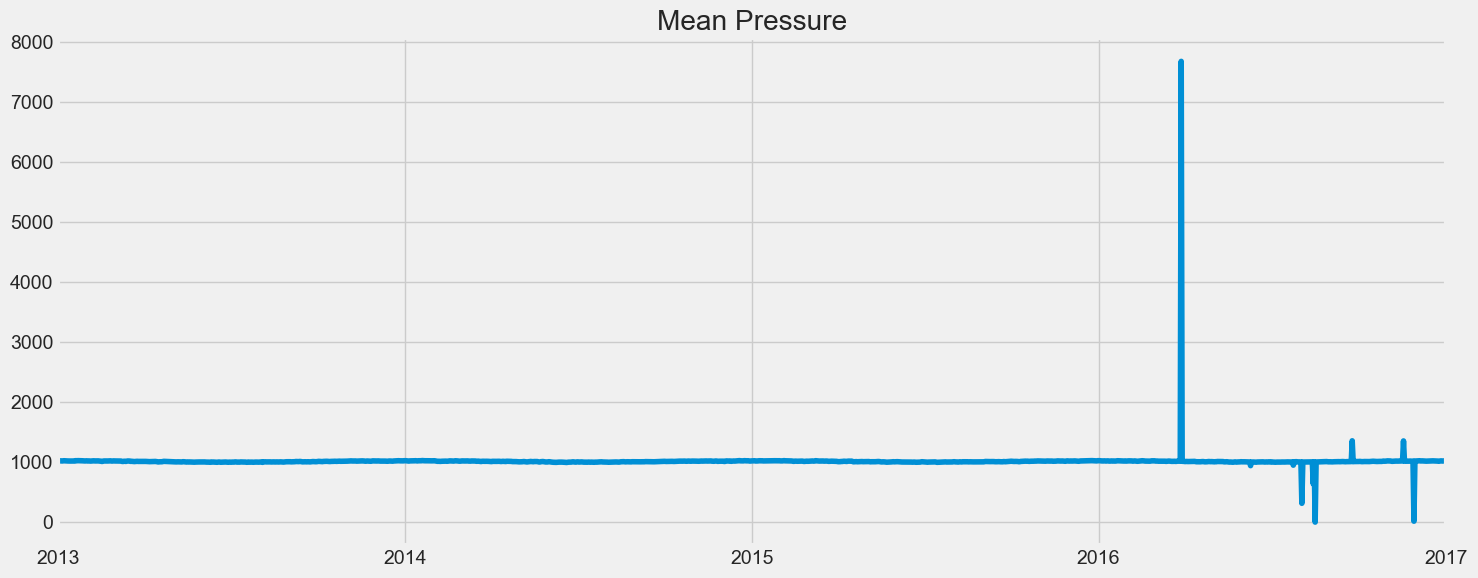

In [9]:
plt.figure(figsize=(15, 6))
df['meanpressure'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Mean Pressure")
plt.tight_layout()
plt.show()

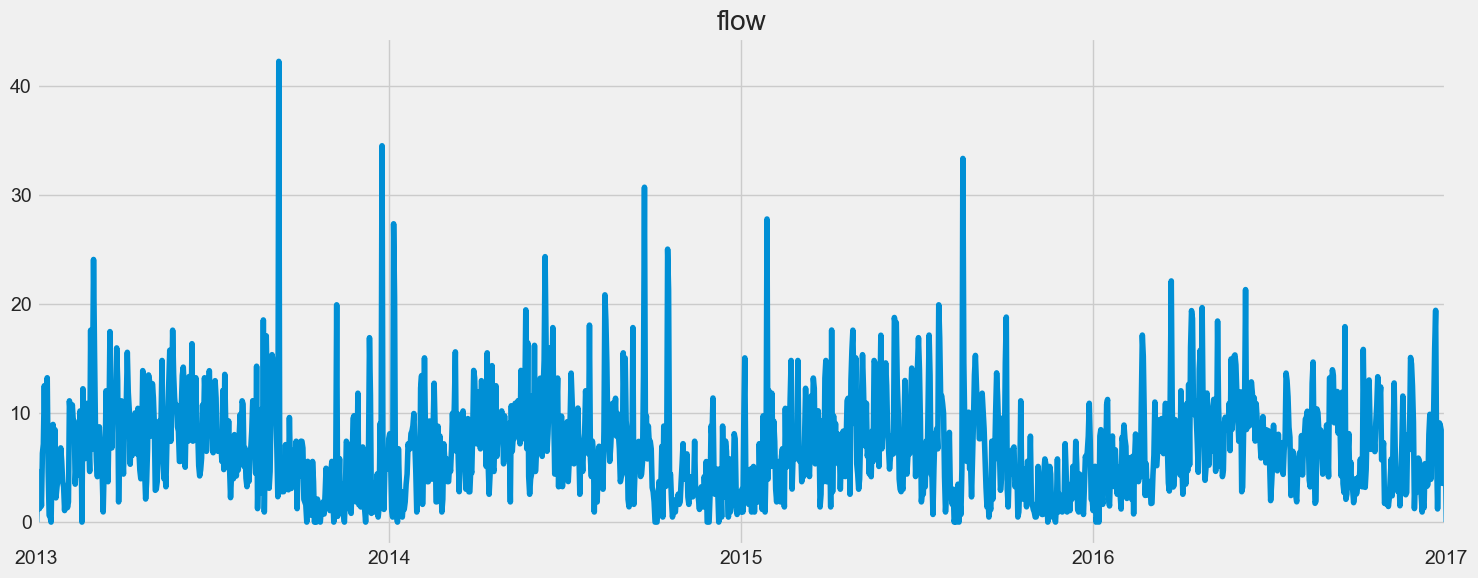

In [11]:
plt.figure(figsize=(15, 6))
df['Flow'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title('flow')
plt.tight_layout()
plt.show()

In [12]:
n_cols = 1
dataset = df["meantemp"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(1462, 1)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [14]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [15]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1096, 1)

In [16]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 60
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[0.12227074],
       [0.04279476],
       [0.0356623 ],
       [0.08151383],
       [0.        ],
       [0.03056769],
       [0.03056769],
       [0.08733624],
       [0.24454148],
       [0.15283843],
       [0.29694323],
       [0.24454148],
       [0.30058224],
       [0.20887918],
       [0.26637555],
       [0.23944687],
       [0.3209607 ],
       [0.23944687],
       [0.19868996],
       [0.16157205],
       [0.15895197],
       [0.1069869 ],
       [0.24454148],
       [0.23944687],
       [0.19104803],
       [0.20378457],
       [0.20960699],
       [0.27001456],
       [0.24836245],
       [0.26637555],
       [0.31179039],
       [0.30567686],
       [0.31441048],
       [0.36681223],
       [0.34934498],
       [0.32478166],
       [0.32605531],
       [0.29344978],
       [0.24454148],
       [0.28820961],
       [0.28275109],
       [0.3018559 ],
       [0.2852984 ],
       [0.31441048],
       [0.34643377],
       [0.40247453],
       [0.25764192],
  

In [17]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [19]:
x_train.shape , y_train.shape

((1402, 60, 1), (1402, 1))

In [20]:
#build a model
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100


44/44 [==============================] - 33s 117ms/step - loss: 0.0470 - mean_absolute_error: 0.1484
Epoch 2/100
44/44 [==============================] - 5s 114ms/step - loss: 0.0060 - mean_absolute_error: 0.0616
Epoch 3/100
44/44 [==============================] - 5s 109ms/step - loss: 0.0049 - mean_absolute_error: 0.0551
Epoch 4/100
44/44 [==============================] - 5s 106ms/step - loss: 0.0050 - mean_absolute_error: 0.0557
Epoch 5/100
44/44 [==============================] - 5s 112ms/step - loss: 0.0047 - mean_absolute_error: 0.0541
Epoch 6/100
44/44 [==============================] - 5s 111ms/step - loss: 0.0045 - mean_absolute_error: 0.0526
Epoch 7/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0044 - mean_absolute_error: 0.0522
Epoch 8/100
44/44 [==============================] - 5s 121ms/step - loss: 0.0044 - mean_absolute_error: 0.0520
Epoch 9/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0044 - mean_absolute_err

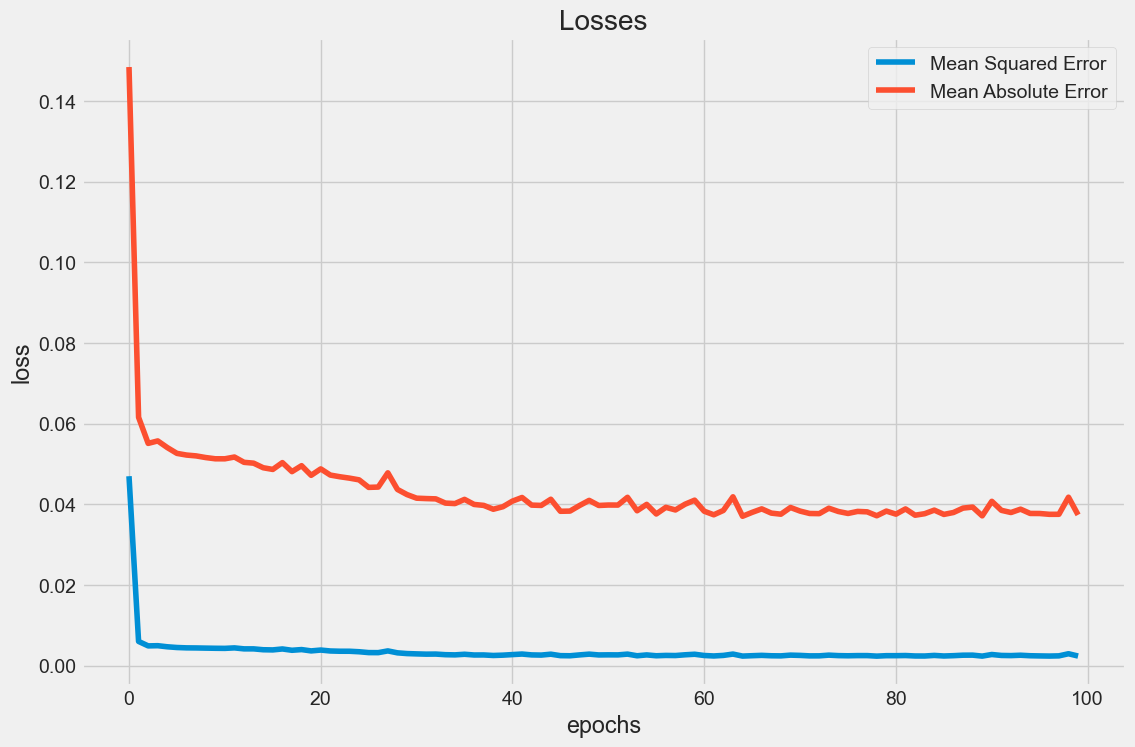

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [24]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))


In [25]:
# Get Prediction
predictions = model.predict(x_test)

12/12 [==============================] - 7s 40ms/step


In [26]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(366, 1)

In [27]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

In [28]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.09

In [29]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,14.809148,14.000000
1,14.277249,14.375000
2,14.426170,15.750000
3,15.414536,15.833333
4,15.681913,17.375000
...,...,...
361,16.876188,17.217391
362,17.140745,15.238095
363,15.774285,14.095238
364,14.713874,15.052632


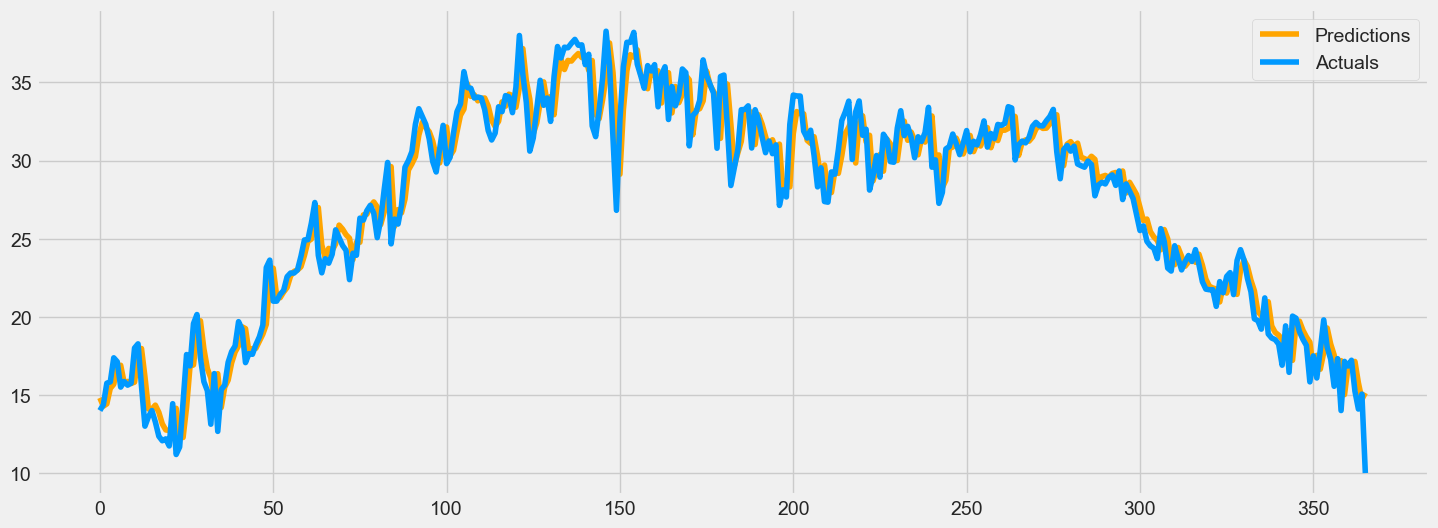

In [77]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'], color='orange')
plt.plot(preds_acts['Actuals'], color='#0099FF')
plt.legend(['Predictions', 'Actuals'])
plt.show()

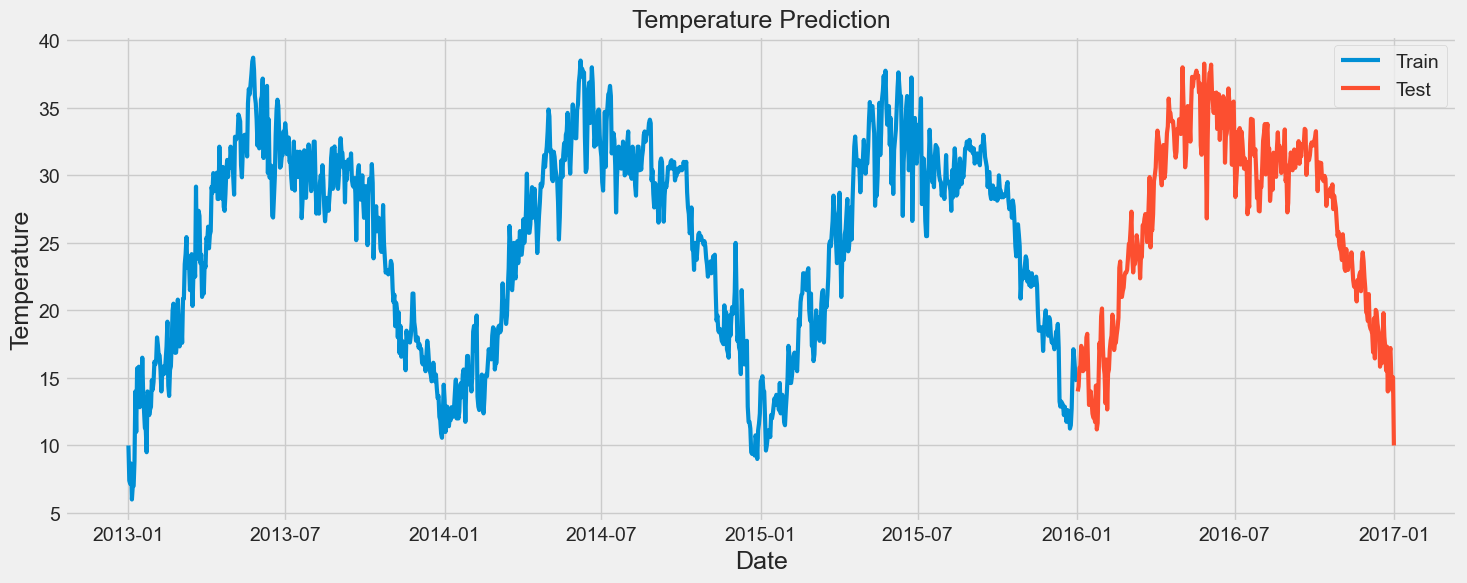

In [31]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

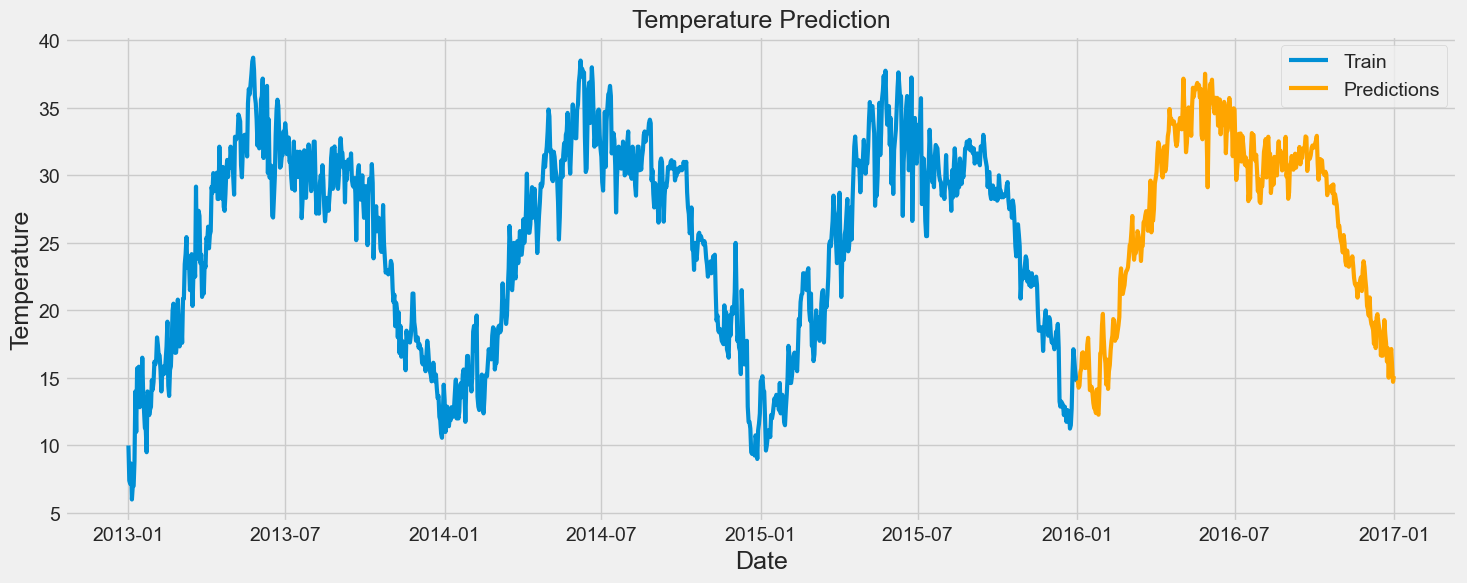

In [67]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3, color='orange')
plt.legend(['Train', 'Predictions'])


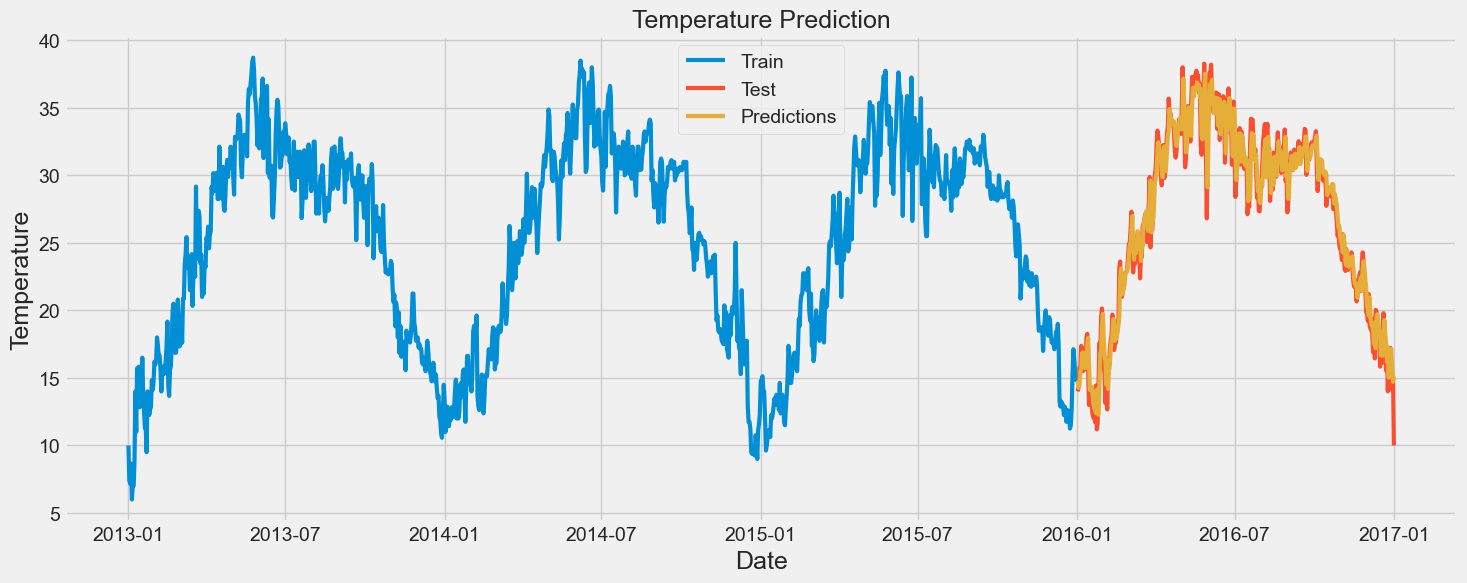

In [33]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

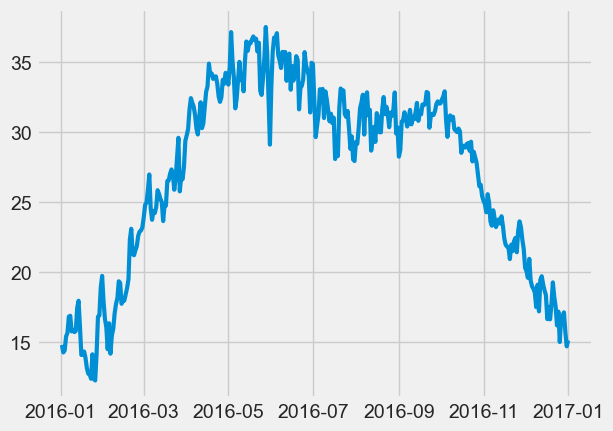

In [34]:
plt.plot(test["Predictions"], linewidth= 3)

In [35]:
!pip install lightgbm

In [36]:
df_train = pd.read_csv(r'D:\Downloads\DailyDelhiClimateTrain.csv')
df_train.rename(columns={'wind_speed': 'Flow'}, inplace=True)
df_train

,date,meantemp,humidity,Flow,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [37]:
df_test = pd.read_csv(r'D:\Downloads\DailyDelhiClimateTest.csv')
df_test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


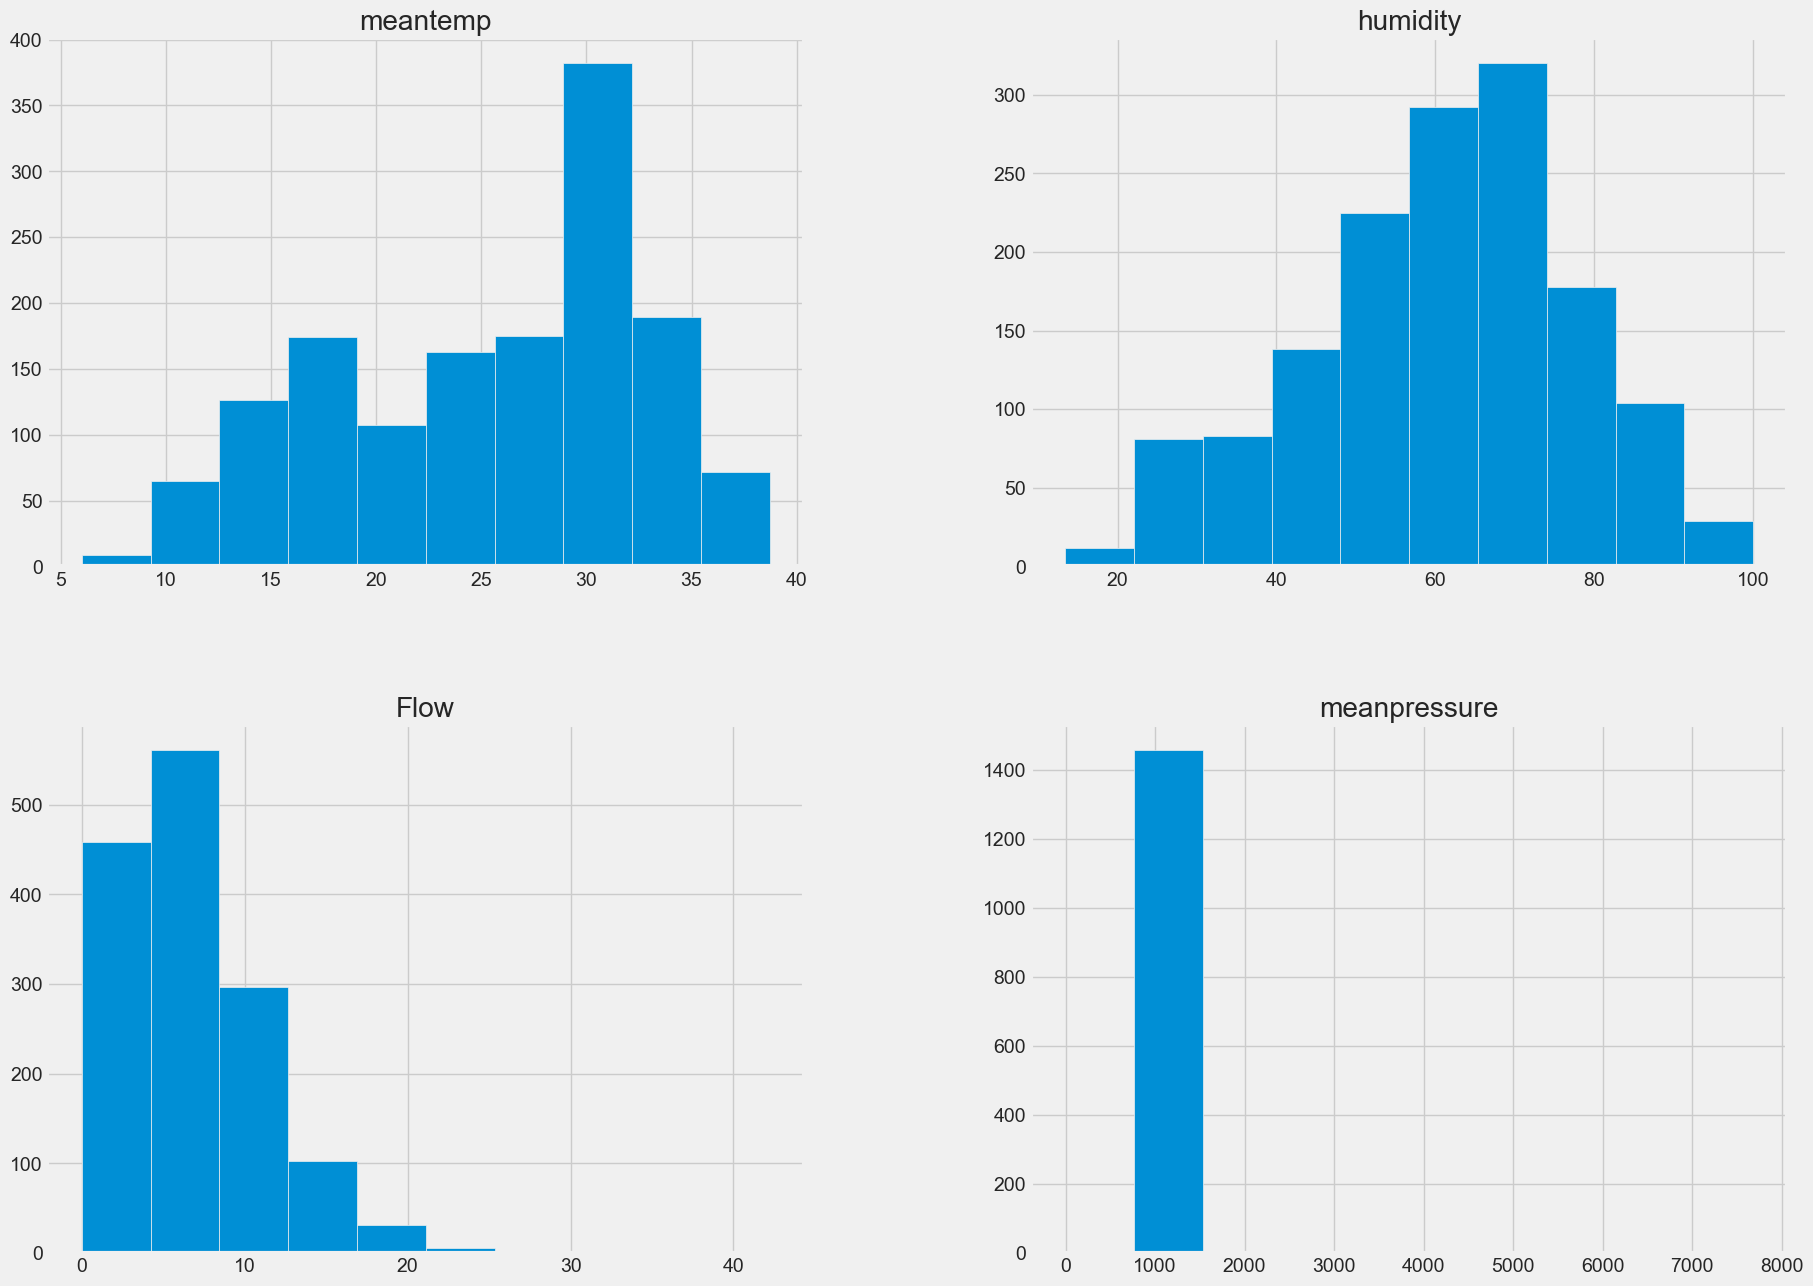

In [38]:
#Numerical Features Histograms (Train)
num_feats = list(df_train.select_dtypes(include=['int64', 'float64', 'int32']).columns)
df_train[num_feats].hist(figsize=(20,15));

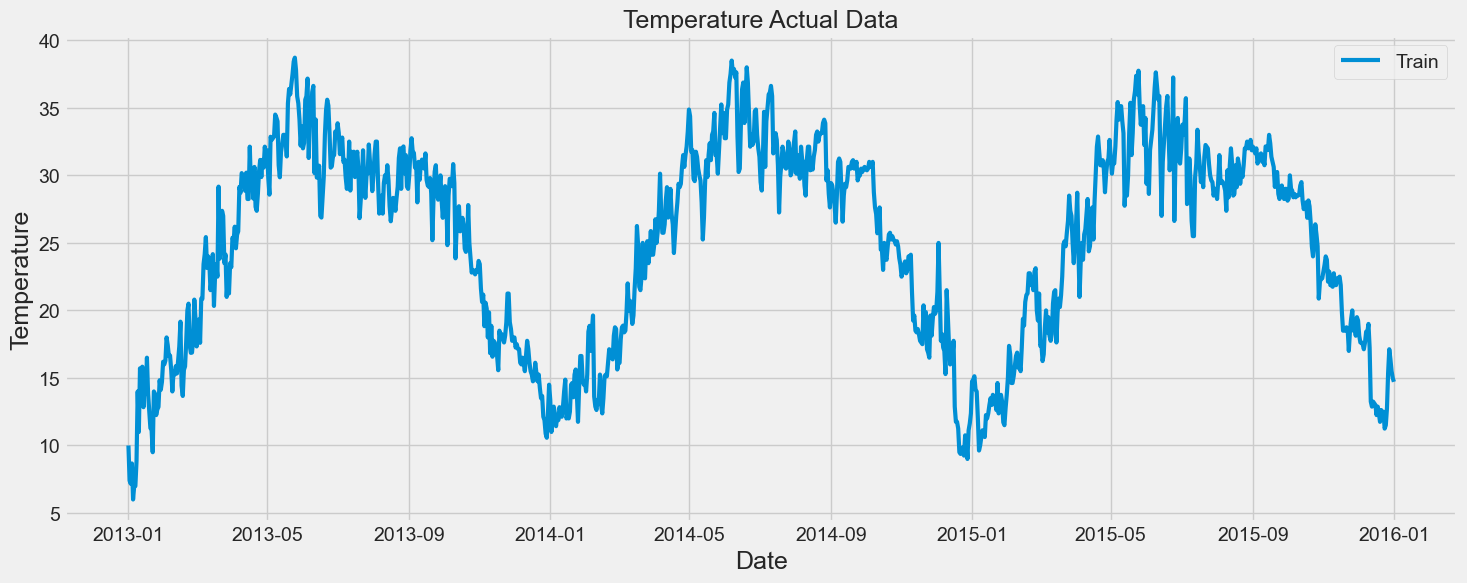

In [64]:
plt.figure(figsize= (16, 6))
plt.title('Temperature Actual Data', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.legend(['Train'])